In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from datetime import datetime, timedelta
import MetaTrader5 as mt5

In [3]:
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("initialization succeed.")

initialization succeed.


In [18]:
df = pd.read_csv('./Data/843451.csv', delimiter=';',  index_col=[0])
df[df['Symbol']=='EURUSD']

Type  Volume  Symbol    Price               Time.1  \
Time                                                                      
2022.07.19 00:45:56  Sell    0.31  EURUSD  1.01457  2022.07.19 01:19:32   
2022.07.18 23:10:09   Buy    0.31  EURUSD  1.01432  2022.07.19 00:42:39   
2022.07.15 22:56:10  Sell    0.32  EURUSD  1.00818  2022.07.18 01:03:26   
2022.07.15 22:02:52   Buy    0.32  EURUSD  1.00753  2022.07.15 22:54:40   
2022.07.12 23:00:00   Buy    0.31  EURUSD  1.00336  2022.07.12 23:00:13   
...                   ...     ...     ...      ...                  ...   
2020.09.14 23:49:37   Buy    0.01  EURUSD  1.18612  2020.09.15 00:05:40   
2020.09.14 00:30:01   Buy    0.01  EURUSD  1.18381  2020.09.14 01:00:00   
2020.09.11 00:04:14   Buy    0.01  EURUSD  1.18165  2020.09.11 00:17:56   
2020.09.10 23:18:06   Buy    0.01  EURUSD  1.18129  2020.09.10 23:35:28   
2020.09.08 23:40:03   Buy    0.01  EURUSD  1.17760  2020.09.09 02:44:27   

                     Price.1  Commission  Swap  Profit  
Time                                                    
2022.07.19 00:45:56  1.01455       -1.70   NaN    0.91  
2022.07.18 23:10:09  1.01463       -1.70 -3.07   14.10  
2022.07.15 22:56:10  1.00832       -1.76  1.86   -6.59  
2022.07.15 22:02:52  1.00785       -1.76   NaN   15.08  
2022.07.12 23:00:00  1.00367       -1.70   NaN   14.22  
...                      ...         ...   ...     ...  
2020.09.14 23:49:37  1.18652       -0.06 -0.06    0.55  
2020.09.14 00:30:01  1.18369       -0.06   NaN   -0.16  
2020.09.11 00:04:14  1.18172       -0.06   NaN    0.10  
2020.09.10 23:18:06  1.18168       -0.06   NaN    0.54  
2020.09.08 23:40:03  1.17687       -0.06 -0.07   -1.01  

[423 rows x 9 columns]

In [16]:
startdate =  datetime(2022, 7, 19, 0, 45, 0) + timedelta(seconds=16200) 
enddate =    datetime(2022, 7, 19, 0, 46, 0) + timedelta(seconds=16200)
df = pd.DataFrame( mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_M1, startdate, enddate)).head()
df['time'] = pd.to_datetime(df["time"], unit="s") #+ timedelta(seconds=+16200) 
df

time     open     high      low    close  tick_volume  \
0 2022-07-19 00:45:00  1.01452  1.01462  1.01444  1.01462            6   
1 2022-07-19 00:46:00  1.01462  1.01470  1.01448  1.01462           10   

   spread  real_volume  
0       8            0  
1       2            0

----------------------

In [21]:
import numpy as np
import pandas as pd

def __statement_preprocess(trading_data):
    """
    This function is used to preprocess the trading_data
    --------------------------------------------------
    Parameters :
    ------------
        - trading_data : Trading Statement pandas-DataFrame
    --------------------------------------------------
    Returns :
    -----------
        -trading_data : pandas-DataFrame
    """

    # Removing Balance rows (price and time is 0)
    trading_data = trading_data.drop( index=trading_data[trading_data.ordertype == 'None'].index).reset_index(drop=True)

    # Correction of Time2 datatype
    trading_data.openorder_time = pd.to_datetime(trading_data.openorder_time)
    trading_data.closeorder_time = pd.to_datetime(trading_data.closeorder_time)

    # Sort by Time2 (close date)
    trading_data = trading_data.sort_values(by='closeorder_time')

    return trading_data

def __main( trading_data: pd.DataFrame) -> None:
    """
    This function is the main body to calculate open/close scores
    --------------------------------------------------
    Parameters :
    ------------
        - trading_data : Trading Statement pandas-DataFrame
    --------------------------------------------------
    Returns :
    -----------
        None
        * Outputs are stored in object variables
    """

    # Fetch prices from server
    prices = pd.DataFrame(trading_data.apply( lambda x: pd.DataFrame(eval(x["openClosestrategies"])) if x["openClosestrategies"] != None else 0, axis = 1))

    # Calculate scores for all scenarios (Score = 11 - rank of each trade among 11 different scenarios)
    # NOTE1: For strategy base price, price fetched from API for Time1/Time2 is used
    # NOTE2: Open_scores/Close_scores range between 0 to 10
    # buy_mask shows if trade is buy or sell
    buy_mask = trading_data.ordertype.str.contains('long', case=False)
    open_scores = 11 - prices.apply(lambda x: 11 if (x[0] == 0) else x[0][:11].close.rank(ascending=buy_mask[x.name]), axis=1)
    close_scores = 11 - prices.apply(lambda x: 11 if (x[0] == 0) else x[0][11:].close.rank(ascending=not buy_mask[x.name]), axis=1)


    index_low_duration = trading_data[trading_data["openClosestrategies"].isin([None])].index
    profit_low_durationp = trading_data[trading_data["openClosestrategies"].isin([None])].profit.values
    open_scores[open_scores.index.isin(index_low_duration)] = np.array( list(map(lambda x: 10 if x>0 else 0, profit_low_durationp))).reshape(len(profit_low_durationp),1)
    close_scores[close_scores.index.isin(profit_low_durationp)] = np.array(list(map(lambda x: 10 if x>0 else 0, profit_low_durationp))).reshape(len(profit_low_durationp),1)
    # renaming open and close scores
    open_scores.rename(columns={0: "-50%", 1: "-40%", 2: "-30%", 3: "-20%", 4: "-10%", 5: "Strategy", 6: "+10%", 7: "+20%", 8: "+30%", 9: "+40%", 10: "+50%"}, inplace=True)
    close_scores.rename(columns={11: "-50%", 12: "-40%", 13: "-30%", 14: "-20%", 15: "-10%", 16: "Strategy", 17: "+10%", 18: "+20%", 19: "+30%", 20: "+40%", 21: "+50%"}, inplace=True)

    # Calculate aggregated mean for scores
    cumulative_open_scores = open_scores.cumsum().div((open_scores.index.values + 1), axis=0)
    cumulative_close_scores = close_scores.cumsum().div((close_scores.index.values + 1), axis=0)

    x = trading_data.closeorder_time.dt.round('D')

    # Aggregate scores on base unit
    open_scores = open_scores.set_index(x).groupby('closeorder_time').mean()
    close_scores = close_scores.set_index(x).groupby('closeorder_time').mean()

    cumulative_open_scores = self.cumulative_open_scores.set_index(x).groupby('closeorder_time').mean()
    cumulative_open_scores["Type"] = "Open"
    cumulative_close_scores = self.cumulative_close_scores.set_index(x).groupby('closeorder_time').mean()
    cumulative_close_scores["Type"] = "Close"

    # Finding final scores
    final_open_score = self.cumulative_open_scores.iat[-1, 5]
    final_close_score = self.cumulative_close_scores.iat[-1, 5]

In [449]:
# df = pd.read_csv('147.csv', index_col=0)
# df.columns

In [552]:
df = pd.read_csv('149.csv', index_col=0)

trading_data = __statement_preprocess(df) 
# Fetch prices from server
prices = pd.DataFrame(trading_data.apply( lambda x: pd.DataFrame(eval(x["openClosestrategies"])) if x["openClosestrategies"] != None else 0, axis = 1))

# buy_mask shows if trade is buy or sell
buy_mask = trading_data.ordertype.str.contains('long', case=False)

# Ratio of profit to price difference
profit_per_pip = abs( trading_data['profit'] /(trading_data.loc[:,'closeorder_price'] - trading_data.loc[:,'openorder_price']))

open_impact =   prices.apply(lambda x: (x[0][:11].close - x[0][:11].close[5]) * (-1 if buy_mask[x.name]  else 1), axis=1).mul(profit_per_pip, axis=0)#.sum(axis=0)
open_impact.rename(columns={0: "-50%", 1: "-40%", 2: "-30%", 3: "-20%", 4: "-10%", 5: "Strategy", 6: "+10%", 7: "+20%", 8: "+30%", 9: "+40%", 10: "+50%"}, inplace=True)
open_impact_return = open_impact.add(trading_data['profit'], axis=0).sum(axis=0)
open_impact_precent = (open_impact_return - open_impact_return[5])/abs(open_impact_return[5]) * 100

# close_impact =  prices.apply(lambda x: (x[0][11:].close - x[0][11:].close[16]) * (-1 if buy_mask[x.name]  else 1), axis=1).mul(profit_per_pip, axis=0)#.sum(axis=0)
# close_impact.rename(columns={11: "-50%", 12: "-40%", 13: "-30%", 14: "-20%", 15: "-10%", 16: "Strategy", 17: "+10%", 18: "+20%", 19: "+30%", 20: "+40%", 21: "+50%"}, inplace=True)
# close_impact_return = close_impact.add(trading_data['profit'], axis=0).sum(axis=0)
# close_impact_precent = (close_impact_return - close_impact_return[5])/close_impact_return[5] * 100


In [540]:
# prices[0][2][:11]
# buy_mask
# open_impact_return

In [554]:
trading_data['profit'].sum()
# profit_per_pip

# open_impact.sum(axis=0)
# open_impact_return
# open_impact_precent

10630.970000000001

In [461]:
# prices[0][0][11:]
# trading_data['profit']
# prices.apply(lambda x: (x[0][11:].close - x[0][11:].close[16]) * (-1 if buy_mask[x.name]  else 1), axis=1)
# prices.apply(lambda x: (x[0][11:].close) * (-1 if buy_mask[x.name]  else 1), axis=1)

In [548]:
fig = plt.figure(figsize=(15, 10))
(ax1, ax2) = fig.subplots(2, 1)#, sharex=True, )

ax1.bar(x=open_impact_precent.index, height=open_impact_precent.values, label='Entry Time')
ax1.set_title('Vinati Jethra')
# ax1.set_title('Jana AlHassanieh')
# ax1.set_title('Sanya Arora')
# ax1.set_title("Leena Othman")
ax1.grid()
ax1.legend()

# ax2.bar(x=close_impact_precent.index, height=close_impact_precent.values, label='Exit time')
# ax2.grid()
# ax2.legend()
plt.savefig('Vinati Jethra.png',  dpi=300)
# plt.savefig('Jana AlHassanieh.png',  dpi=300)
# plt.savefig('Sanya Arora.png',  dpi=300)
# plt.savefig('Leena_Othman.png',  dpi=300)

In [499]:
trading_data.iloc[2]
# trading_data[[ 'openorder_price', 'closeorder_price', 'profit', 'pip_value']]

symbol                                                              USDCAD
ordertype                                                             Long
openorder_time                                         2022-05-13 11:17:32
openorder_price                                                    1.30123
openorder_volume                                                      0.01
openorder_commission                                                     0
closeorder_time                                        2022-05-13 11:31:05
closeorder_price                                                    1.3014
closeorder_volume                                                     0.01
closeorder_commission                                                    0
takeprofit                                                         1.30139
stopLoss                                                           1.30042
profit                                                                0.13
swap                     

In [315]:
# prices[0][0][:11]

In [49]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import Evaluation_Attributes as Darwin 
from Data_Operation import Trading_Data
from datetime import datetime, timedelta
import scipy.stats
from Data_Operation import Comput_pipV, Market_Data
from Trader_Analytics import Trader_Analytics

# Get Test Trader Data

In [46]:
test_data =  Trading_Data(id = 147).send_post_request
test_data

symbol ordertype       openorder_time  openorder_price  openorder_volume  \
0               None  2022-05-27T09:59:55          0.00000              0.00   
1   EURCHF     Short  2022-05-27T10:59:17          1.02854              5.00   
2   CADJPY      Long  2022-05-27T09:59:55         99.76400              5.00   
3   AUDJPY      Long  2022-05-30T10:02:23         91.37200              5.00   
4   AUDCAD     Short  2022-05-30T10:00:04          0.91081              5.00   
..     ...       ...                  ...              ...               ...   
75  EURJPY     Short  2022-06-16T16:20:02        138.77500              0.20   
76  EURJPY      Long  2022-06-16T17:11:46        139.19000              2.00   
77  EURJPY     Short  2022-06-16T20:02:19        139.70700              0.24   
78  EURJPY      Long  2022-06-08T14:59:58        144.13400              5.00   
79  GBPCHF     Short  2022-06-17T08:59:29          1.18637              5.00   

    openorder_commission      closeorder_time  closeorder_price  \
0                      0  2022-05-27T09:59:55           0.00000   
1                      0  2022-05-27T12:02:23           1.02754   
2                      0  2022-05-27T12:08:56          99.73700   
3                      0  2022-05-30T11:07:38          91.57300   
4                      0  2022-05-30T14:55:16           0.90980   
..                   ...                  ...               ...   
75                     0  2022-06-16T16:20:08         144.13400   
76                     0  2022-06-16T19:59:35         139.71300   
77                     0  2022-06-16T20:02:38         144.13400   
78                     0  2022-06-16T20:02:38         140.89000   
79                     0  2022-06-17T09:55:41           1.18537   

    closeorder_volume  closeorder_commission  ...  balance  \
0                0.00                      0  ...        0   
1                5.00                      0  ...        0   
2                5.00                      0  ...        0   
3                5.00                      0  ...        0   
4                5.00                      0  ...        0   
..                ...                    ...  ...      ...   
75               0.20                      0  ...        0   
76               2.00                      0  ...        0   
77               0.24                      0  ...        0   
78               5.00                      0  ...        0   
79               5.00                      0  ...        0   

                                     openTradeDetails  \
0                                                None   
1   [{'symbol': 'CADJPY', 'openorder_time': '2022-...   
2   [{'symbol': 'CADJPY', 'openorder_time': '2022-...   
3   [{'symbol': 'AUDCAD', 'openorder_time': '2022-...   
4   [{'symbol': 'AUDCAD', 'openorder_time': '2022-...   
..                                                ...   
75  [{'symbol': 'EURJPY', 'openorder_time': '2022-...   
76  [{'symbol': 'EURJPY', 'openorder_time': '2022-...   
77  [{'symbol': 'EURJPY', 'openorder_time': '2022-...   
78  [{'symbol': 'USDCHF', 'openorder_time': '2022-...   
79  [{'symbol': 'GBPCHF', 'openorder_time': '2022-...   

                                  openClosestrategies  type     id  \
0                                                None  None  11976   
1   [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11497   
2   [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11496   
3   [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11499   
4   [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11498   
..                                                ...   ...    ...   
75  [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11571   
76  [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11572   
77  [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11573   
78  [{'id': 1, 'candlewindow': '-50% (star', 'utct...  None  11524   
79  [{'id': 1, 'candlewindow': '-50% (

In [51]:
ta = Trader_Analytics(trader_data=test_data)

In [52]:
ta.Growth

45.53508000000013

In [68]:
df = ta.cumulative_return_all_per_deal#.values[-1][0]

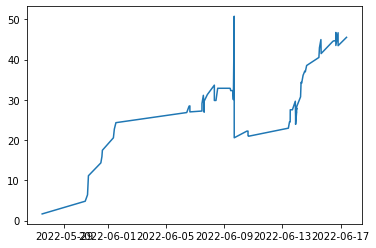

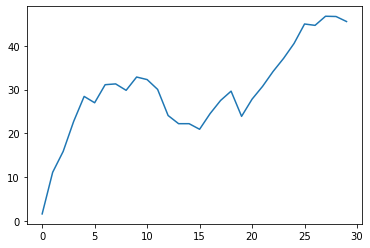

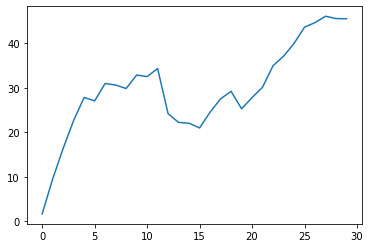

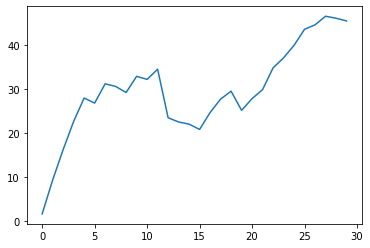

In [147]:
import numpy as np
import scipy.ndimage

plt.plot( df['Cumulative Return'])
plt.show()

scale = 30/len(df['Cumulative Return'])
# Resampled by a factor of 0.2 with nearest interpolation
plt.plot(scipy.ndimage.zoom( df['Cumulative Return'], scale, order = 0))
plt.show()
# Resampled by a factor of 0.2 with bilinear interpolation:
plt.plot(scipy.ndimage.zoom( df['Cumulative Return'], scale, order = 1))
plt.show()
# Resampled by a factor of 0.2 with cubic interpolation:
plt.plot(scipy.ndimage.zoom( df['Cumulative Return'], scale, order = 3))
#****************************************************************************************

In [109]:
df['Cumulative Return']

closeorder_time
2022-05-27 12:08:56     1.66080
2022-05-30 11:07:38     4.81724
2022-05-30 14:55:16     6.41052
2022-05-30 16:25:09    11.14980
2022-05-31 12:53:30    14.33576
                         ...   
2022-06-16 16:20:08    43.51028
2022-06-16 19:59:35    46.67920
2022-06-16 20:02:38    43.46004
2022-06-16 20:02:38    43.46004
2022-06-17 09:55:41    45.53508
Name: Cumulative Return, Length: 78, dtype: float64